In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [45]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("/content/SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
df

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Yes
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Yes
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Yes
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Yes


In [46]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)

In [47]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [48]:
df = df[df["hour"] == 12]
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,12,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,12,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,12,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,12,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,12,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [49]:
df = df.drop(['hour'], axis=1)


In [50]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


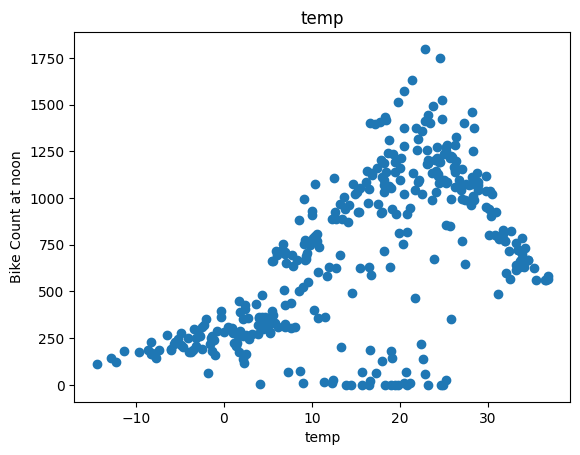

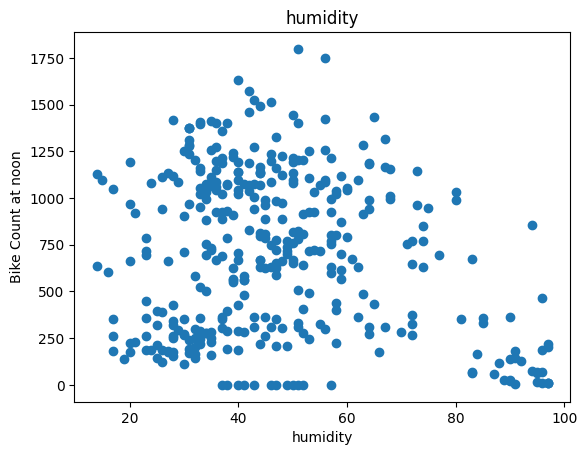

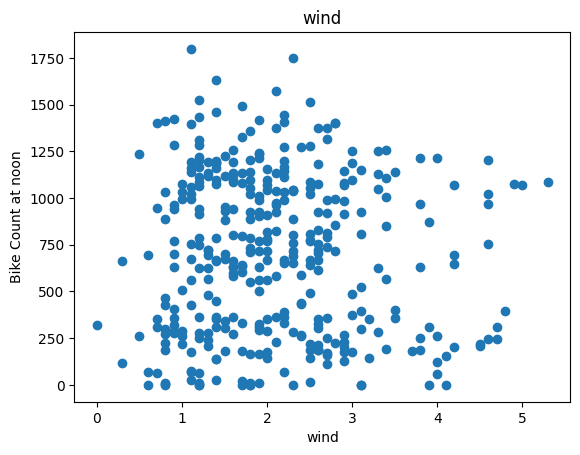

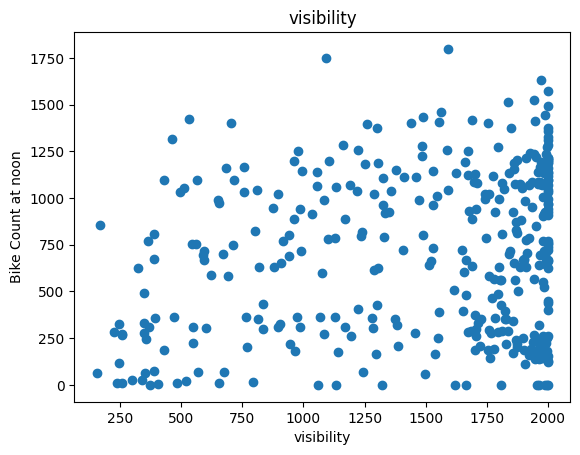

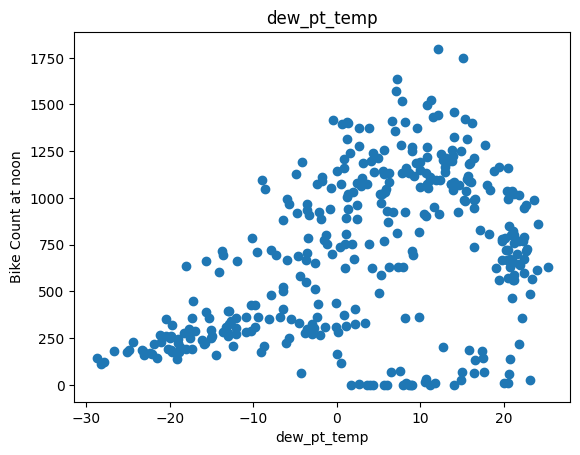

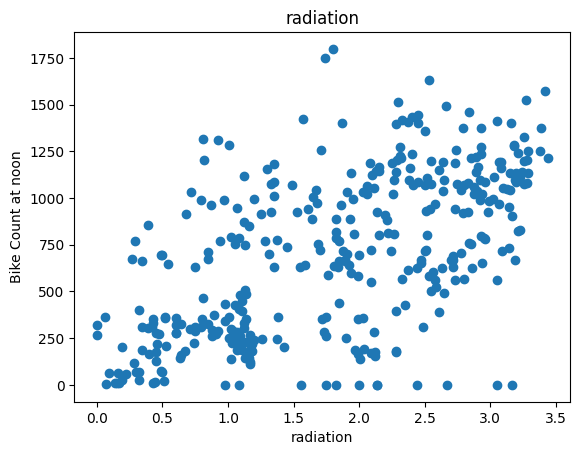

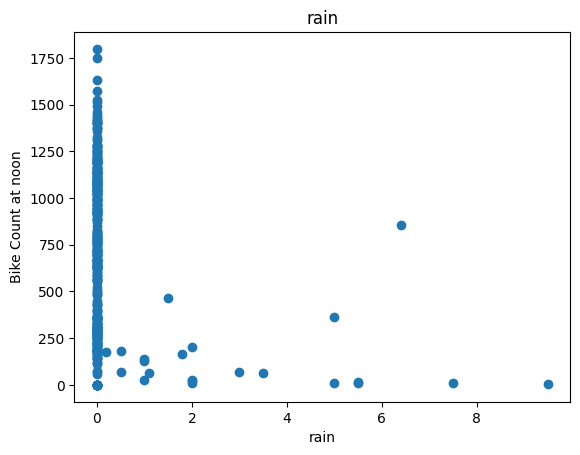

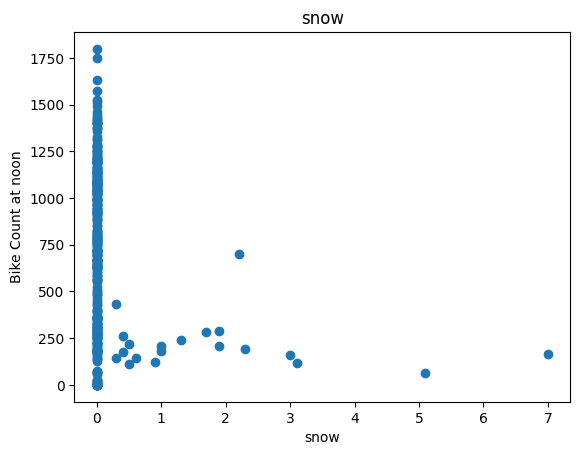

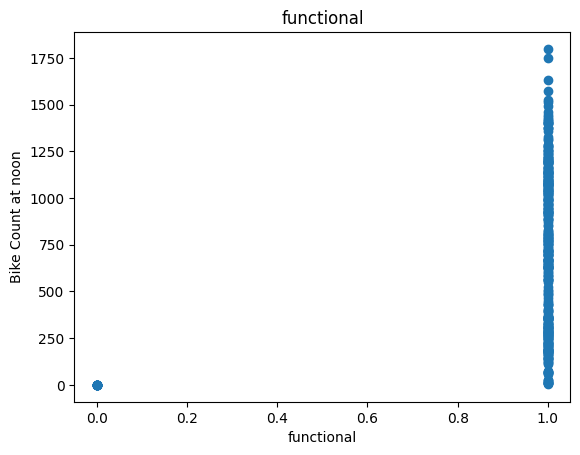

In [51]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at noon")
  plt.xlabel(label)
  plt.show()

In [52]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [53]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


#Train/Val/test Dataset

In [54]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [55]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X, y))

  return data, X, y

In [56]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [57]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [58]:
print(temp_reg.coef_, temp_reg.intercept_)

[[22.01444292]] [368.71830995]


In [59]:
temp_reg.score(X_test_temp, y_test_temp)

0.31333263084696683

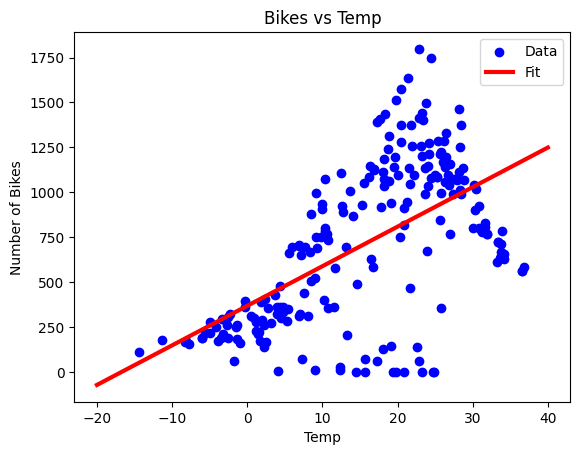

In [60]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color='red', linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

#Multiple Linear Regression

In [61]:
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [62]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [63]:
all_reg.score(X_train_all, y_train_all)

0.46900495803417463

In [64]:
y_predict_lr = all_reg.predict(X_test_all)

In [65]:
y_predict_lr

array([[1106.78326536],
       [1037.26380113],
       [ 874.41249323],
       [ 822.11360723],
       [ 140.5909178 ],
       [ 281.64359896],
       [1004.02250622],
       [ 857.84251858],
       [ 659.32734022],
       [ 392.10845967],
       [ 687.37305938],
       [1060.04753827],
       [ 507.84737387],
       [ 829.39481531],
       [ 546.9798443 ],
       [ 803.46077173],
       [ 827.72037013],
       [ 283.56317867],
       [  57.88558225],
       [1208.60839678],
       [ 813.3658645 ],
       [ 843.82055043],
       [ 463.28162399],
       [ 591.28065962],
       [1130.8081944 ],
       [ 522.37345192],
       [ 648.98663222],
       [1235.11154976],
       [ 948.49372998],
       [ 744.06021335],
       [ 418.99856826],
       [ 349.54255974],
       [ 419.15354599],
       [ 454.13944829],
       [ 178.57100782],
       [ 717.08640993],
       [ 621.01512636],
       [1073.04487199],
       [ 735.17765587],
       [1234.54815496],
       [1049.37257703],
       [ 747.508

#Regression with Neural Net

In [66]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [67]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [68]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [69]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [70]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp, verbose=0, epochs=1000, validation_data=(X_val_temp, y_val_temp)
)

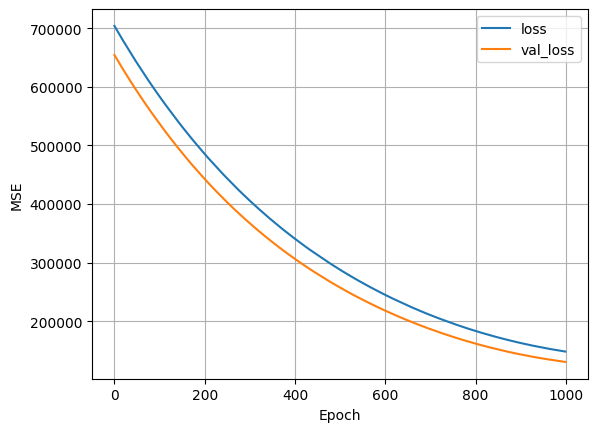

In [71]:
plot_loss(history)

4/4 [==============================] - 0s 6ms/step


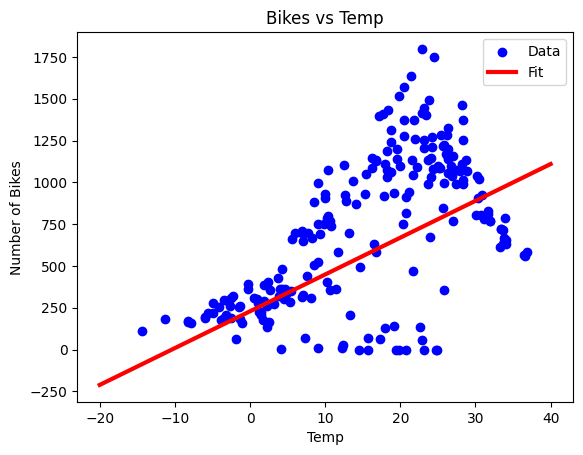

In [72]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color='red', linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

#Neural Nets

In [76]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [77]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

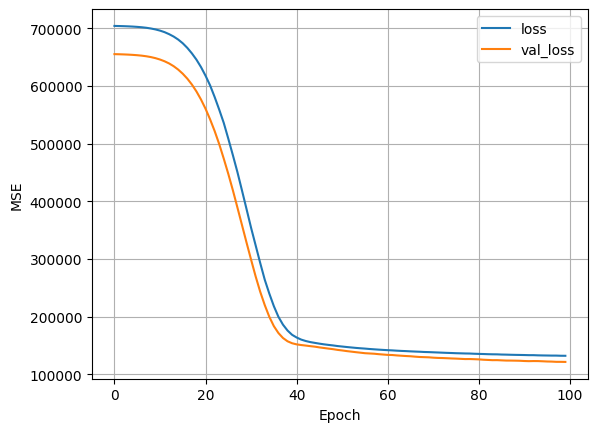

In [78]:
plot_loss(history)

4/4 [==============================] - 0s 9ms/step


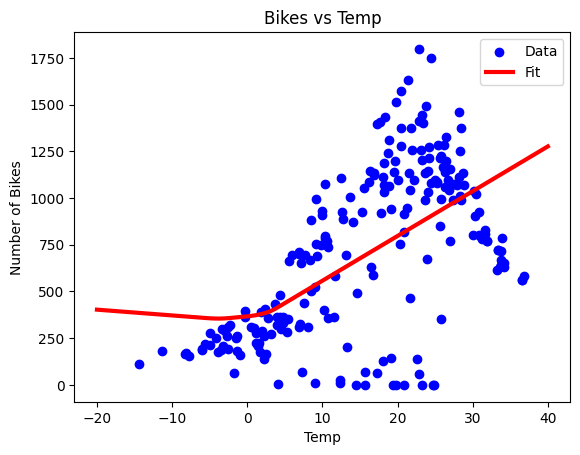

In [79]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color='red', linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

In [80]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
all_normalizer.adapt(X_train_all)

nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [81]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

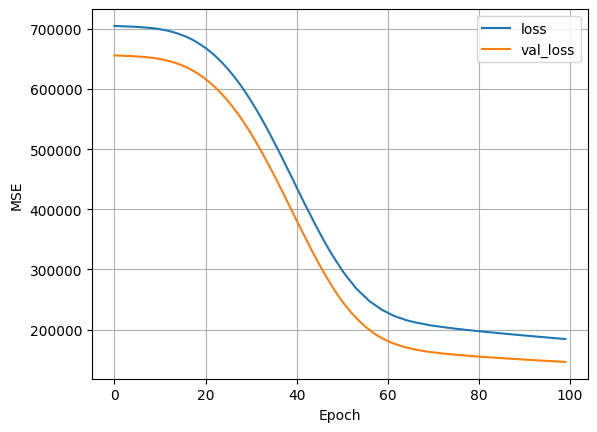

In [82]:
plot_loss(history)

In [83]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 7ms/step


In [84]:
def MSE(y_pred, y_real):
  return (np.square(y_pred-y_real)).mean()

In [85]:
MSE(y_pred_lr, y_test_all)

73141.05368355356

In [86]:
MSE(y_pred_nn, y_test_all)

188132.84924179432

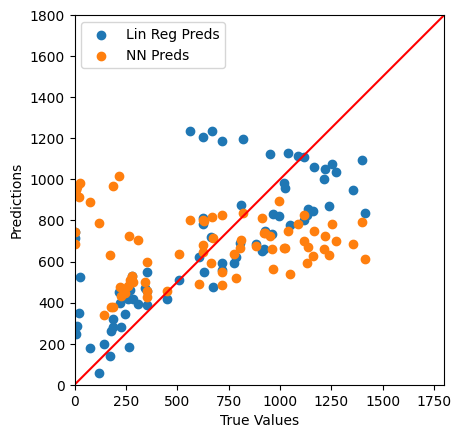

In [87]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")